In [1]:
import cv2
import numpy as np
import tensorflow as tf
from utils import (
    L2Normalization,
    ArcLayer,
    ArcLoss
)
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

2024-11-11 20:46:14.616663: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-11 20:46:14.644482: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-11 20:46:14.650496: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-11 20:46:14.668728: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-11 20:46:16.591970: W tensorflow/compiler/tf2

# Set parameters

In [2]:
lr = 1e-5
alpha = 1.0
epochs = 5
pooling = "avg"
arcloss = True
batch_size = 32
num_classes = 10
input_shape = (112, 112, 1)

output_func = "softmax" if num_classes > 2 else "sigmoid"
loss = "categorical_crossentropy" if num_classes > 2 else "binary_crossentropy"
# loss parameter will change if arcloss is True

# Load dataset

In [3]:
# load mnist dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# get validation data from train
x_val_percent = int(x_train.shape[0] * 0.15)
x_val = x_train[:x_val_percent]
y_val = y_train[:x_val_percent]
x_train = x_train[x_val_percent:]
y_train = y_train[x_val_percent:]

# select the first 100 samples to speed up the build process
# x_train = x_train[:100]
# y_train = y_train[:100]
# x_val = x_val[:100]
# x_test = x_test[:100]
# y_test = y_test[:100]
# y_val = y_val[:100]

# resize the images to 224x224
x_train = np.array([cv2.resize(x, input_shape[:2]) for x in x_train])
x_test = np.array([cv2.resize(x, input_shape[:2]) for x in x_test])
x_val = np.array([cv2.resize(x, input_shape[:2]) for x in x_val])
# add the channel dimension
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)
# transform the data to images
x_train, x_test, x_val = x_train / 255.0, x_test / 255.0, x_val / 255.0
# labels to categorical
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)

In [4]:
# show labels and their counts
np.unique(np.argmax(y_train, axis=-1), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([5032, 5719, 5069, 5209, 4943, 4647, 5010, 5304, 5005, 5062]))

In [5]:
# show shape of categorical data
y_train.shape, y_test.shape

((51000, 10), (10000, 10))

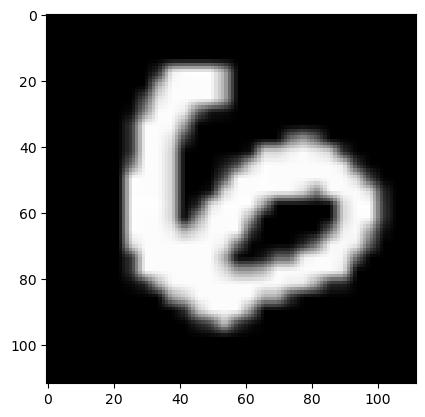

In [6]:
image = x_train[0].copy()
plt.imshow(image, cmap='gray')

# Define model

In [7]:
# instantiate the model
model = MobileNetV2(
    input_shape=input_shape,
    alpha=alpha,
    include_top=False,
    weights=None,
    pooling="avg",
)

# add the output layer
if arcloss:
    x = model.output
    x = L2Normalization()(x)
    x = ArcLayer(
        units=num_classes,
        activity_regularizer=tf.keras.regularizers.L1(1e-4),
        kernel_regularizer=tf.keras.regularizers.L2(1e-4),
    )(x)
    loss = ArcLoss()
    model = Model(inputs=model.input, outputs=x)

else:
    x = model.output
    x = Dense(
        units=num_classes,
        activation=output_func,
        use_bias=True,
        name="Logits",
        activity_regularizer=tf.keras.regularizers.L1(1e-4),
        kernel_regularizer=tf.keras.regularizers.L2(1e-4),
    )(x)
    model = Model(inputs=model.input, outputs=x)

I0000 00:00:1731368787.396258  115521 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731368787.396772  115521 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731368787.460049  115521 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731368787.460223  115521 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731368787.460283  115521 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [8]:
# check last layer
# model.summary()

# Set optimizer

In [9]:
optimizer = Adam(learning_rate=lr)

# Compile model

In [10]:
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[
        "acc",
    ],
)

# Fit model

In [11]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    shuffle=True,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
)

2024-11-11 20:46:33.440371: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2558976000 exceeds 10% of free system memory.
2024-11-11 20:46:36.031597: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2558976000 exceeds 10% of free system memory.


Epoch 1/5


I0000 00:00:1731368827.933679  115647 service.cc:146] XLA service 0x7feb00014c00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731368827.933726  115647 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
I0000 00:00:1731368827.933733  115647 service.cc:154]   StreamExecutor device (1): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2024-11-11 20:47:08.925417: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-11 20:47:12.058913: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


   3/1594 ━━━━━━━━━━━━━━━━━━━━ 59s 37ms/step - acc: 0.0885 - loss: 33.7970    

I0000 00:00:1731368853.037372  115647 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1594/1594 ━━━━━━━━━━━━━━━━━━━━ 152s 61ms/step - acc: 0.2564 - loss: 31.8540 - val_acc: 0.1024 - val_loss: 33.3919
Epoch 2/5
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 67s 42ms/step - acc: 0.5784 - loss: 27.1659 - val_acc: 0.0990 - val_loss: 36.5038
Epoch 3/5
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - acc: 0.7676 - loss: 18.0003 - val_acc: 0.1137 - val_loss: 41.0667
Epoch 4/5
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 59s 37ms/step - acc: 0.8949 - loss: 8.7293 - val_acc: 0.1137 - val_loss: 63.0999
Epoch 5/5
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 59s 37ms/step - acc: 0.9448 - loss: 4.7694 - val_acc: 0.8042 - val_loss: 14.1183


# Evaluate model

313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - acc: 0.7850 - loss: 15.1099


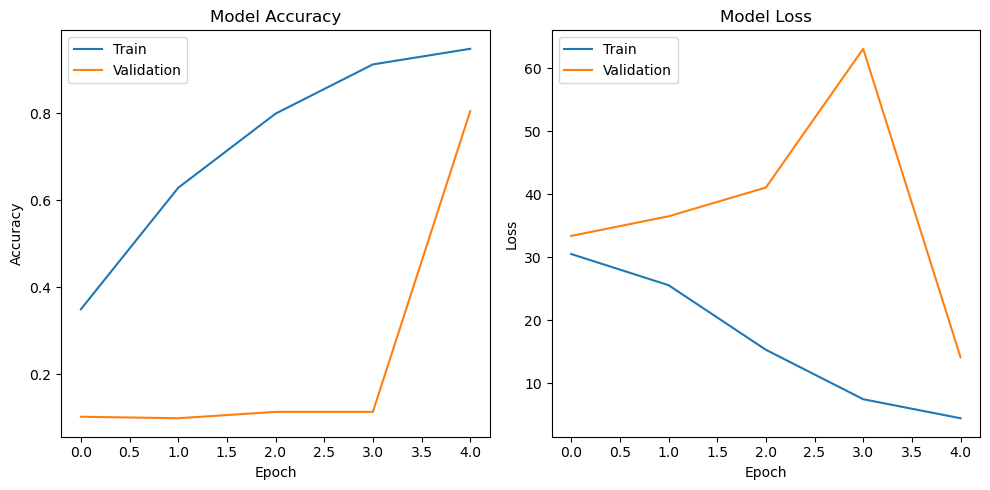

In [12]:
# evaluate the model
model.evaluate(x_test, y_test)

# plot train acc and loss
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(history.history["acc"])
ax[0].plot(history.history["val_acc"])
ax[0].set_title("Model Accuracy")
ax[0].set_ylabel("Accuracy")
ax[0].set_xlabel("Epoch")
ax[0].legend(["Train", "Validation"], loc="upper left")

ax[1].plot(history.history["loss"])
ax[1].plot(history.history["val_loss"])
ax[1].set_title("Model Loss")
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("Epoch")
ax[1].legend(["Train", "Validation"], loc="upper left")

plt.tight_layout()
plt.show()